In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [115]:
DATA_PATH = '../data/training/final/travel_insight.csv'
VAL_DATA_PATH = '../data/validation/final/travel_insight.csv'
travel = pd.read_csv(DATA_PATH)
travel_val = pd.read_csv(VAL_DATA_PATH)
travel.head()

,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_MISSION_CHECK,TRAVEL_PURPOSE_22,TRAVEL_PURPOSE_1,TRAVEL_PURPOSE_4,TRAVEL_PURPOSE_6,...,TRAVEL_LIKE_SGG_3,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE_1,TRAVEL_MOTIVE_2,TRAVEL_MOTIVE_3,TRAVEL_COMPANIONS_NUM,TRAVEL_STATUS_RESIDENCE_CODE,TRAVEL_STATUS_DESTINATION_CODE
0,a_a014262,1;11;2;22;,2022-10-29,2022-10-30,자가용,2;1;22,1,1,0,0,...,41280.0,서울특별시,경기,자녀 동반 여행,3.0,5.0,7.0,1.0,11.0,41.0
1,a_a006728,21;24;5;22;26;27;,2022-10-10,2022-10-11,자가용,6;1;22,1,0,0,0,...,41280.0,서울특별시,경기,자녀 동반 여행,6.0,1.0,3.0,3.0,11.0,41.0
2,a_a015745,1;2;6;,2022-10-31,2022-11-03,대중교통 등,13;3;28,0,1,0,1,...,26350.0,서울특별시,인천,나홀로 여행,7.0,8.0,2.0,0.0,11.0,28.0
3,a_a010544,21;22;24;26;,2022-11-01,2022-11-02,자가용,1;22;26,1,0,0,0,...,28710.0,서울특별시,경기,나홀로 여행,1.0,5.0,2.0,0.0,11.0,41.0
4,a_a012058,1;4;10;12;21;22;26;,2022-11-05,2022-11-06,대중교통 등,1;21;22,1,1,1,0,...,41360.0,강원도,경기,2인 여행(가족 외),1.0,2.0,3.0,1.0,42.0,41.0


In [116]:
# 학습에 사용할 피처값 선언
features_for_training = [
    'activity_payment_sum',
    'activity_payment_count',
    'activity_store_count',
    'activity_history_rows',
    'activity_type_unique',
    'lodging_payment_sum',
    'lodging_payment_count',
    'lodging_store_count',
    # 'IS_FAILED_TRIP',
    'visit_trip_days',
    'visit_move_cnt',
    'AGE_GRP',
    'EDU_NM',
    'MARR_STTS',
    'FAMILY_MEMB',
    'JOB_NM',
    'INCOME',
    'HOUSE_INCOME',
    'TRAVEL_TERM',
    'TRAVEL_NUM',
    'TRAVEL_LIKE_SIDO_1',
    'TRAVEL_LIKE_SGG_1',
    'TRAVEL_LIKE_SIDO_2',
    'TRAVEL_LIKE_SGG_2',
    'TRAVEL_LIKE_SIDO_3',
    'TRAVEL_LIKE_SGG_3',
    'TRAVEL_MOTIVE_1',
    'TRAVEL_MOTIVE_2',
    'TRAVEL_MOTIVE_3',
    'TRAVEL_COMPANIONS_NUM',
    'TRAVEL_STATUS_RESIDENCE_CODE',
    'TRAVEL_STATUS_DESTINATION_CODE'
]

In [117]:
# 데이터 선언
X = travel[features_for_training]
y = travel['IS_FAILED_TRIP']

In [118]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

In [119]:
# # SMOTE
# smote = SMOTE(random_state=42)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [125]:
# 레이블에서 0, 1의 비율 계산
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# 모델 호출
xgb_clf = XGBClassifier(
    n_estimators=100,       # 결정트리 기반 모델에만 가능
    # max_depth=3,
    learning_rate=5e-6,
    random_state=42,
    scale_pos_weight=ratio
)

In [127]:
# 학습
# xgb_clf.fit(X_train_over, y_train_over)
xgb_clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [128]:
# 예측
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

In [129]:
# 평가
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
# accuracy score, MSE, R2 score
print("="*5+"Train data"+"="*70)
print(f'Acc : {accuracy_score(y_true=y_train, y_pred=y_pred_train)}')
print(f'MSE : {mean_squared_error(y_true=y_train, y_pred=y_pred_train)}')
print(f'R2 : {r2_score(y_true=y_train, y_pred=y_pred_train)}')
print("="*5+"Confusion Matrix"+"="*63)
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
print("="*5+"Classification_report"+"="*58)
print(classification_report(y_true=y_train, y_pred=y_pred_train))
print("="*5+"Test data"+"="*70)
print(f'Acc : {accuracy_score(y_true=y_test, y_pred=y_pred_test)}')
print(f'MSE : {mean_squared_error(y_true=y_test, y_pred=y_pred_test)}')
print(f'R2 : {r2_score(y_true=y_test, y_pred=y_pred_test)}')
print("="*5+"Confusion Matrix"+"="*63)
print(confusion_matrix(y_true=y_test, y_pred=y_pred_test))
print("="*5+"Classification_report"+"="*58)
print(classification_report(y_true=y_test, y_pred=y_pred_test))

=====Train data======================================================================
Acc : 0.6086226203807391
MSE : 0.39137737961926095
R2 : -0.8952903307346252
=====Confusion Matrix===============================================================
[[1509 1022]
 [ 376  665]]
=====Classification_report==========================================================
              precision    recall  f1-score   support

         0.0       0.80      0.60      0.68      2531
         1.0       0.39      0.64      0.49      1041

    accuracy                           0.61      3572
   macro avg       0.60      0.62      0.59      3572
weighted avg       0.68      0.61      0.63      3572

=====Test data======================================================================
Acc : 0.5375571521881124
MSE : 0.46244284781188766
R2 : -1.2767329415372473
=====Confusion Matrix===============================================================
[[620 477]
 [231 203]]
=====Classification_report===================

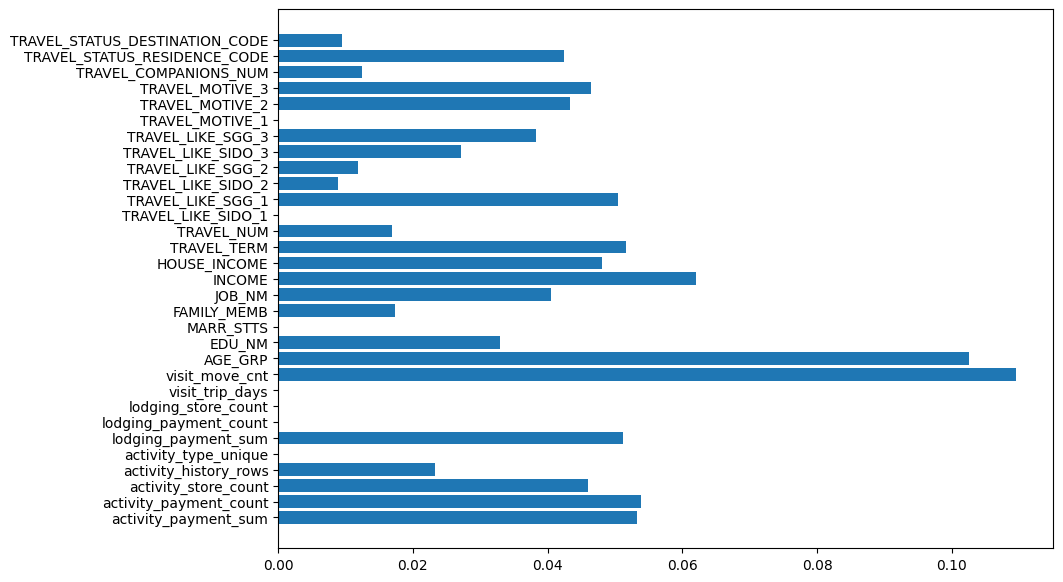

In [130]:
import matplotlib.pyplot as plt

# 피처 중요도 시각화
plt.figure(figsize=(10,7))
plt.barh(X.columns, xgb_clf.feature_importances_)
plt.show()